# Hackathon

## Set up notebook

In [2]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
from tabulate import tabulate
from tqdm.auto import tqdm

import wandb


In [3]:
sns.set_theme()
plt.rc('figure', figsize=(8, 4), dpi=100)


### Set up Weights & Biases tracking

To make this interesting, we're tracking everyone's progress via W&B. Don't worry 
Please replace `<Your name here>` by your own name (or a nickname).

If you just want to play around without uploading your runs, set `offline` to `True`

In [4]:
# Used for identifying runs on the W&B dashboard
# name = "<Your name here>"
name = "Vincent Brouwers"

# Whether or not to upload runs to W&B
upload = True

In [5]:
if name == "<Your name here>":
  raise Exception("RTFM")

## Load Data

In [6]:
df = pd.read_csv("datasets/full.csv")
all_feature_names = df.iloc[:, 1:].columns.to_list()

X = df.iloc[:, 1:].to_numpy()
y = df.iloc[:, 0].to_numpy()
feature_names = df.iloc[:, 1:].columns.to_numpy()    
labels = ["not buggy", "buggy"]

In [7]:
# Split data into 70% train and 30% test subsets

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    shuffle=True,
)

In [8]:
class_weight = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

## Defining our models

The value of features can differ greatly between models, which is why we test across a number of common and easy-to-train ones. We also look at the effect of regularization, as this can also affect the impact of feature selection.

* Decision Tree
* Random Forrest
* Logistic Regression
* Logistic Regression (with L1 regularization)
* Logistic Regression (with L2 regularization)
* K Nearest Neighbors (with k=15)


_There is no need to change anything here. These are just helper functions to quickly test our data_

In [9]:
classifiers = [
        (DecisionTreeClassifier(), ),
        (RandomForestClassifier(n_estimators=200, min_samples_leaf=10, max_depth=20, class_weight="balanced"), ),
        # (SVC(gamma="auto", probability=True, class_weight=class_weight), ),
        (LogisticRegression(max_iter=1000, class_weight="balanced"), ),
        (LogisticRegression(max_iter=1000, penalty="l1", solver="liblinear", class_weight="balanced"), "_l1"),
        (LogisticRegression(max_iter=1000, penalty="l2", class_weight="balanced"), "_l2"),
        (KNeighborsClassifier(n_neighbors=15), )
    ]
classifiers = [(c[0], c[0].__class__.__name__ + (c[1] if len(c) > 1 else "")) for c in classifiers]

## Setting up our testing code

These functions enable us to easily train our set of classifiers using specific features. They also help us keep track of all experiments

*There's no need to change anything here, either*

In [10]:
def test_classifier(clf, feature_indices):
    if feature_indices is None or len(feature_indices) == 0:
        feature_indices = list(range(X_train.shape[1]))
    clf.fit(X_train[:, feature_indices], y_train)

    # predicted = clf.predict(X_test)
    y_probas = clf.predict_proba(X_test[:, feature_indices])
    y_pred = y_probas.argmax(axis=1)

    scores = {
        f"Accuracy": metrics.accuracy_score(y_test, y_pred),
        f"F1": metrics.f1_score(y_test, y_pred),
        f"Precision": metrics.precision_score(y_test, y_pred),
        f"Recall": metrics.recall_score(y_test, y_pred),
    }
    return scores, y_probas


def test_selection(feature_indices, compare=None, log=True, log_wandb=False):
    scores = {}
    table = []
    for classifier, name in tqdm(classifiers, smoothing=0):
        scores_ = test_classifier(classifier, feature_indices=feature_indices)[0]
        scores[name] = scores_

    # This has no place being one statement, but I just want it to be one
    scores["Average"] = dict(
        zip(
            next(iter(scores.values())).keys(),
            np.mean(list(zip(*(x.values() for x in scores.values()))), axis=1),
        )
    )

    for name, scores_ in scores.items():
        row = [name]
        row += [
            f"{s:0.4f}" + (f"{baseline[name][m]:0.4f}" if compare else "")
            for m, s in scores_.items()
        ]

        row = {
            m: f"{s:0.4f}" + (f" ({s - compare[name][m]:0.4f})" if compare else "")
            for m, s in scores_.items()
        }
        row = {"Classifier": name, **row}
        table.append(row)

        for metric, score in scores_.items():
            rep = f"{score:0.4f}"
            if compare:
                rep += f" ({compare[name][metric]:0.4f})"

    print(tabulate(table, headers="keys"))

    return scores


def test_selector(selector, run_suffix=None, wandb=True, **config_kwargs):
    used_features = selector.get_support()
    used_feature_names = selector.get_feature_names_out(feature_names)
    print(
        f"Selected {sum(used_features)}/{len(feature_names)} features: \n{used_feature_names}"
    )

    scores = test_selection(used_features, compare=baseline)

    if wandb:
        log_scores(
            scores,
            used_feature_names,
            selector.__class__.__name__,
            run_suffix,
            **config_kwargs,
        )


def log_scores(scores, used_features, method_name, method_suffix=None, **config_kwargs):
    print(used_features)
    if all([isinstance(x, int) for x in used_features]):
        print("Detected features as string indices")
        used_feature_names = feature_names[used_features]
    elif all([isinstance(x, str) for x in used_features]):
        print("Detected features as string indices")
        used_feature_names = used_features
    else:
        raise Exception(
            "Whoops, expected used_features to be a list of names or indices"
        )

    used_features_tbl = {name: name in used_feature_names for name in feature_names}
    time = datetime.now().strftime("%H:%M:%S")
    method = method_name + ("_" + method_suffix if method_suffix else "")
    wandb.init(
        project="sogeti-hackathon-feature-selection",
        entity="vincentbrouwers",
        name="-".join([name, method, time]),
        anonymous="allow",
        tags=dict(name=name),
        mode="online" if upload else "offline",
        config=dict(
            features=used_features_tbl,
            name=name,
            method=method,
            method_name=method_name,
            method_suffix=method_suffix,
            **config_kwargs,
        ),
    )

    wscores = {
        f"{clf}_{mtr}": score
        for clf, mtrs in scores.items()
        for mtr, score in mtrs.items()
    }
    wandb.log(
        {
            "feature_count": len(used_feature_names),
            "used_features": wandb.Table(
                columns=["feature", "used"],
                # Just temporary until I have an actual method of filtering features
                data=list(used_features_tbl.items()),
            ),
            # "roc": wandb.plot.roc_curve(y_test, y_probas, labels),
            # "pr": wandb.plot.pr_curve(y_test, y_probas, labels),
            **wscores,
        }
    )
    wandb.finish(quiet=True)


## Feature Selection

In [11]:
baseline = test_selection(None, compare=False)
log_scores(baseline, feature_names, "Baseline")

  0%|          | 0/6 [00:00<?, ?it/s]

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Classifier                Accuracy      F1    Precision    Recall
----------------------  ----------  ------  -----------  --------
DecisionTreeClassifier      0.7691  0.6154       0.6915    0.5544
RandomForestClassifier      0.753   0.6453       0.6186    0.6745
LogisticRegression          0.7552  0.5839       0.673     0.5157
LogisticRegression_l1       0.7554  0.5842       0.6737    0.5157
LogisticRegression_l2       0.7552  0.5839       0.673     0.5157
KNeighborsClassifier        0.7562  0.5647       0.697     0.4746
Average                     0.7574  0.5963       0.6711    0.5418
['h1' 'h2' 'N1' 'N2' 'complexity' 'loc' 'lloc' 'sloc' 'comments' 'multi'
 'blank' 'single_comments' 'no_of_files' 'no_of_added_files'
 'no_of_added_python_files' 'no_of_modified_files'
 'no_of_modified_python_files' 'no_of_copied_files'
 'no_of_copied_python_files' 'no_of_deleted_files'
 'no_of_deleted_python_files' 'author_previous_commits'
 'author_previous_file_changes']
Detected features as string i

wandb: Currently logged in as: vincentbrouwers (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


### Filtering methods

#### Variance threshold

A simple method to filter out superfluous features, is to remove ones with a low variance. The idea here is that these features offer relatively little information. 

*Note: Variance depends on the magnitude our values and our data is not normalized. It's not really possible to set 1 threshold for all features*

---

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html

In [12]:
from sklearn.feature_selection import VarianceThreshold

var = VarianceThreshold(threshold=0.3).fit(X_train)

test_selector(var, threshold=var.threshold)

Selected 19/23 features: 
['h1' 'h2' 'N1' 'N2' 'complexity' 'loc' 'lloc' 'sloc' 'comments' 'multi'
 'blank' 'single_comments' 'no_of_files' 'no_of_added_files'
 'no_of_added_python_files' 'no_of_modified_files'
 'no_of_modified_python_files' 'no_of_deleted_files'
 'no_of_deleted_python_files']


  0%|          | 0/6 [00:00<?, ?it/s]

Classifier              Accuracy         F1               Precision        Recall
----------------------  ---------------  ---------------  ---------------  ---------------
DecisionTreeClassifier  0.7697 (0.0005)  0.6166 (0.0012)  0.6921 (0.0006)  0.5560 (0.0016)
RandomForestClassifier  0.7570 (0.0040)  0.6496 (0.0043)  0.6252 (0.0066)  0.6761 (0.0016)
LogisticRegression      0.7554 (0.0003)  0.5842 (0.0003)  0.6737 (0.0007)  0.5157 (0.0000)
LogisticRegression_l1   0.7557 (0.0003)  0.5845 (0.0003)  0.6744 (0.0007)  0.5157 (0.0000)
LogisticRegression_l2   0.7554 (0.0003)  0.5842 (0.0003)  0.6737 (0.0007)  0.5157 (0.0000)
KNeighborsClassifier    0.7568 (0.0005)  0.5665 (0.0018)  0.6973 (0.0002)  0.4770 (0.0024)
Average                 0.7583 (0.0010)  0.5976 (0.0014)  0.6727 (0.0016)  0.5427 (0.0009)
['h1' 'h2' 'N1' 'N2' 'complexity' 'loc' 'lloc' 'sloc' 'comments' 'multi'
 'blank' 'single_comments' 'no_of_files' 'no_of_added_files'
 'no_of_added_python_files' 'no_of_modified_files'
 'no_

wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


#### Statistical corrolation threshold

Another method of supervised feature filtering is to calculate corrolation statistics between each feature and the label(s). 

We use the chi-squared test to measure the label's (positive) dependence on features and select the best ones with various thresholding methods.

---

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html<br/>
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html

In [13]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2, r_regression, mutual_info_classif

# Select (k=)10 most corrolated features 
selector = SelectKBest(chi2, k=10).fit(X_train, y_train)
test_selector(selector, "chi2")

# Select the features that hit the 50th percentile (median score or better)
selector = SelectPercentile(chi2, percentile=50).fit(X_train, y_train)
test_selector(selector, "chi2")

# # Select (k=)10 most corrolated features 
# selector = SelectKBest(r_regression, k=10).fit(X_train, y_train)
# test_selector(selector, "r_regression")

# # Select the features that hit the 50th percentile (median score or better)
# selector = SelectPercentile(r_regression, percentile=50).fit(X_train, y_train)
# test_selector(selector, "r_regression")

# # Select (k=)10 most corrolated features 
# selector = SelectKBest(mutual_info_classif, k=10).fit(X_train, y_train)
# test_selector(selector, "mutual_info_classif")

# # Select the features that hit the 50th percentile (median score or better)
# selector = SelectPercentile(mutual_info_classif, percentile=50).fit(X_train, y_train)
# test_selector(selector, "mutual_info_classif")

Selected 10/23 features: 
['loc' 'sloc' 'multi' 'no_of_files' 'no_of_added_files'
 'no_of_added_python_files' 'no_of_modified_files'
 'no_of_modified_python_files' 'no_of_deleted_files'
 'no_of_deleted_python_files']


  0%|          | 0/6 [00:00<?, ?it/s]

Classifier              Accuracy          F1                Precision         Recall
----------------------  ----------------  ----------------  ----------------  ----------------
DecisionTreeClassifier  0.7546 (-0.0145)  0.5672 (-0.0481)  0.6877 (-0.0037)  0.4827 (-0.0717)
RandomForestClassifier  0.7442 (-0.0089)  0.6308 (-0.0146)  0.6075 (-0.0112)  0.6559 (-0.0185)
LogisticRegression      0.7533 (-0.0019)  0.5609 (-0.0230)  0.6890 (0.0160)   0.4730 (-0.0427)
LogisticRegression_l1   0.7536 (-0.0019)  0.5616 (-0.0226)  0.6893 (0.0156)   0.4738 (-0.0419)
LogisticRegression_l2   0.7533 (-0.0019)  0.5609 (-0.0230)  0.6890 (0.0160)   0.4730 (-0.0427)
KNeighborsClassifier    0.7589 (0.0027)   0.5768 (0.0121)   0.6947 (-0.0024)  0.4932 (0.0185)
Average                 0.7530 (-0.0044)  0.5764 (-0.0199)  0.6762 (0.0051)   0.5086 (-0.0332)
['loc' 'sloc' 'multi' 'no_of_files' 'no_of_added_files'
 'no_of_added_python_files' 'no_of_modified_files'
 'no_of_modified_python_files' 'no_of_deleted_fil

wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Selected 11/23 features: 
['loc' 'sloc' 'multi' 'blank' 'no_of_files' 'no_of_added_files'
 'no_of_added_python_files' 'no_of_modified_files'
 'no_of_modified_python_files' 'no_of_deleted_files'
 'no_of_deleted_python_files']


  0%|          | 0/6 [00:00<?, ?it/s]

Classifier              Accuracy          F1                Precision         Recall
----------------------  ----------------  ----------------  ----------------  ----------------
DecisionTreeClassifier  0.7538 (-0.0153)  0.5589 (-0.0565)  0.6933 (0.0019)   0.4682 (-0.0862)
RandomForestClassifier  0.7436 (-0.0094)  0.6317 (-0.0136)  0.6058 (-0.0129)  0.6600 (-0.0145)
LogisticRegression      0.7530 (-0.0021)  0.5611 (-0.0229)  0.6877 (0.0147)   0.4738 (-0.0419)
LogisticRegression_l1   0.7530 (-0.0024)  0.5611 (-0.0231)  0.6877 (0.0140)   0.4738 (-0.0419)
LogisticRegression_l2   0.7530 (-0.0021)  0.5611 (-0.0229)  0.6877 (0.0147)   0.4738 (-0.0419)
KNeighborsClassifier    0.7549 (-0.0013)  0.5687 (0.0040)   0.6872 (-0.0098)  0.4851 (0.0105)
Average                 0.7519 (-0.0055)  0.5738 (-0.0225)  0.6749 (0.0038)   0.5058 (-0.0360)
['loc' 'sloc' 'multi' 'blank' 'no_of_files' 'no_of_added_files'
 'no_of_added_python_files' 'no_of_modified_files'
 'no_of_modified_python_files' 'no_of_del

wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [14]:
selector

SelectPercentile(percentile=50, score_func=<function chi2 at 0x7fc6100f67a0>)

#### Model-specific feature importance

Some models allow us to directly see the contribution of each feature. This allows us to easily remove the fields that our model extracts the least amount of information from. We always test the effect our selection methods on multiple model types. Does te type of reference model the model affect our testing models differently?

---

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html

Selected 5/23 features: 
['N1' 'N2' 'complexity' 'no_of_deleted_python_files'
 'author_previous_commits']


  0%|          | 0/6 [00:00<?, ?it/s]

Classifier              Accuracy          F1                Precision         Recall
----------------------  ----------------  ----------------  ----------------  ----------------
DecisionTreeClassifier  0.7103 (-0.0588)  0.3472 (-0.2681)  0.6966 (0.0051)   0.2313 (-0.3231)
RandomForestClassifier  0.7017 (-0.0513)  0.4258 (-0.2195)  0.5937 (-0.0250)  0.3320 (-0.3425)
LogisticRegression      0.6980 (-0.0572)  0.4327 (-0.1513)  0.5782 (-0.0948)  0.3457 (-0.1700)
LogisticRegression_l1   0.6977 (-0.0577)  0.4336 (-0.1506)  0.5770 (-0.0967)  0.3473 (-0.1684)
LogisticRegression_l2   0.6980 (-0.0572)  0.4327 (-0.1513)  0.5782 (-0.0948)  0.3457 (-0.1700)
KNeighborsClassifier    0.6899 (-0.0663)  0.3931 (-0.1717)  0.5650 (-0.1321)  0.3014 (-0.1732)
Average                 0.6993 (-0.0581)  0.4109 (-0.1854)  0.5981 (-0.0730)  0.3172 (-0.2246)
['N1' 'N2' 'complexity' 'no_of_deleted_python_files'
 'author_previous_commits']
Detected features as string indices


wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


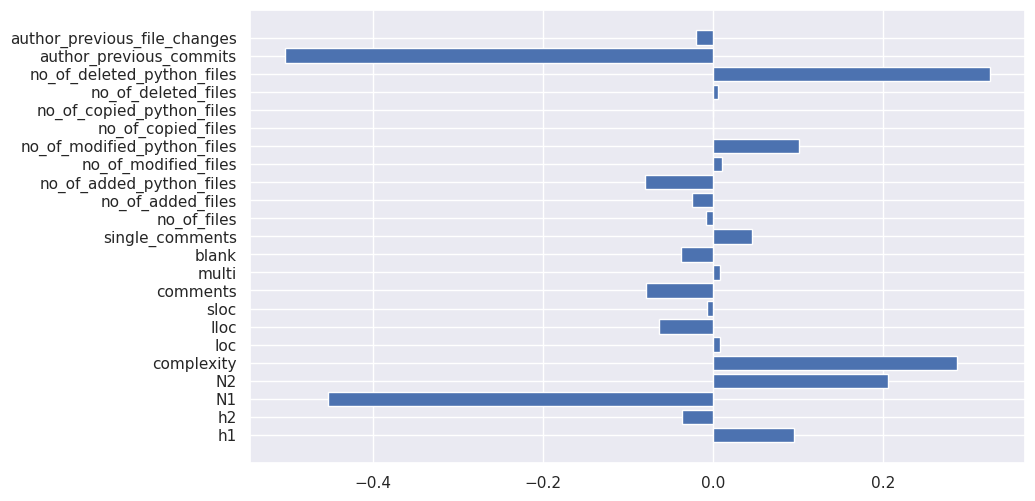

In [15]:
from sklearn.feature_selection import SelectFromModel

plt.figure(figsize=(10, 6))

# clf1 = RandomForestClassifier(n_estimators=200).fit(X_train, y_train)
# plt.barh(feature_names, clf1.feature_importances_)
# selector = SelectFromModel(clf1, threshold="1.5 * mean", prefit=True)

clf2 = LogisticRegression(max_iter=1000).fit(X_train, y_train)
plt.barh(feature_names, clf2.coef_.flatten())
selector = SelectFromModel(clf2, threshold="1 * mean", prefit=True)


test_selector(selector)

### Wrapper

#### Recursive Feature Elimination (RFE)


RFE works in a similar fashion as the previous method, namely that it uses a model's built-in feature significance values to filter out redundant features. Where RFE differs from the "naive" filtering aproach, is that it only removes one feature at a time, after which the entire model is retrained again. Removal of corrolated or inter-dependent features can change the distribution of significance of the remaining features, which this approach mitigates.


---

**Example:**

A simple example of how the result of RFE differs from "naive filtering", is when two features are 100% corrolated. Each of them may be fairly meaningful on their own, though when they're both present, their contribution has to be shared between them. This thus gives them a lower feature importance. 

Let's say we have a model with the following feature importances:

`a=15%`, `b=20%`, `c=50%`, `d=15%`, where `a`, `b` , and `c` are fully independent of eachother, but `d` is 100% corrolated to `a`. 

Naïvely removing the two least contributing features, would leave us with `b=35%` and `c=65%`. If we instead first eliminate `c` (`a` is equally valid), a new model might give us these importances:

`a=30%`, `b=20%`, `c=50%`

This time, `b` will be purged, leaving us with

`a=40%`, `c=60%`

---

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html


In [16]:
from sklearn.feature_selection import RFE

clf = LogisticRegression(max_iter=1000)
selector = RFE(clf, n_features_to_select=5, step=1, verbose=1)
selector = selector.fit(X_train, y_train)

test_selector(selector)

Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Selected 5/23 features: 
['N1' 'N2' 'complexity' 'no_of_deleted_python_files'
 'author_previous_commits']


  0%|          | 0/6 [00:00<?, ?it/s]

Classifier              Accuracy          F1                Precision         Recall
----------------------  ----------------  ----------------  ----------------  ----------------
DecisionTreeClassifier  0.7101 (-0.0591)  0.3478 (-0.2676)  0.6940 (0.0025)   0.2321 (-0.3223)
RandomForestClassifier  0.7026 (-0.0505)  0.4223 (-0.2230)  0.5982 (-0.0204)  0.3263 (-0.3481)
LogisticRegression      0.6980 (-0.0572)  0.4327 (-0.1513)  0.5782 (-0.0948)  0.3457 (-0.1700)
LogisticRegression_l1   0.6980 (-0.0574)  0.4338 (-0.1504)  0.5777 (-0.0959)  0.3473 (-0.1684)
LogisticRegression_l2   0.6980 (-0.0572)  0.4327 (-0.1513)  0.5782 (-0.0948)  0.3457 (-0.1700)
KNeighborsClassifier    0.6899 (-0.0663)  0.3931 (-0.1717)  0.5650 (-0.1321)  0.3014 (-0.1732)
Average                 0.6994 (-0.0579)  0.4104 (-0.1859)  0.5985 (-0.0726)  0.3164 (-0.2254)
['N1' 'N2' 'complexity' 'no_of_deleted_python_files'
 'author_previous_commits']
Detected features as string indices


wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


#### Sequential Feature Selection

This Sequential Feature Selector adds (forward selection) or removes (backward selection) features until the desired amount of features is reached. At each stage, it produces candidate feature sets that include (forward) or exclude (backward) one feature compared to the previous stage. The candidate sets are scored by training new models on them and only the best scoring one is kept.

Forwards and backwards do not have to yield the same feature sets, though none is necessarily better. Their performance can differ depending on the amount and size of models that need to be trained to reach the desired amount of features.

---

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html

In [17]:
from sklearn.feature_selection import SequentialFeatureSelector

direction = "forward"
# direction = "backward"

clf = LogisticRegression(max_iter=1000)
selector = SequentialFeatureSelector(clf, n_features_to_select=5, direction=direction, scoring="f1", n_jobs=-1)

selector = selector.fit(X_train, y_train)

test_selector(selector)

Selected 5/23 features: 
['complexity' 'multi' 'blank' 'no_of_modified_python_files'
 'no_of_deleted_python_files']


  0%|          | 0/6 [00:00<?, ?it/s]

Classifier              Accuracy          F1                Precision         Recall
----------------------  ----------------  ----------------  ----------------  ----------------
DecisionTreeClassifier  0.7479 (-0.0212)  0.5444 (-0.0710)  0.6841 (-0.0073)  0.4521 (-0.1023)
RandomForestClassifier  0.7334 (-0.0196)  0.6200 (-0.0254)  0.5904 (-0.0282)  0.6527 (-0.0218)
LogisticRegression      0.7503 (-0.0048)  0.5646 (-0.0193)  0.6737 (0.0008)   0.4859 (-0.0298)
LogisticRegression_l1   0.7503 (-0.0051)  0.5646 (-0.0196)  0.6737 (0.0001)   0.4859 (-0.0298)
LogisticRegression_l2   0.7503 (-0.0048)  0.5646 (-0.0193)  0.6737 (0.0008)   0.4859 (-0.0298)
KNeighborsClassifier    0.7477 (-0.0086)  0.5485 (-0.0162)  0.6790 (-0.0181)  0.4601 (-0.0145)
Average                 0.7467 (-0.0107)  0.5678 (-0.0285)  0.6625 (-0.0087)  0.5038 (-0.0380)
['complexity' 'multi' 'blank' 'no_of_modified_python_files'
 'no_of_deleted_python_files']
Detected features as string indices


wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


### Own selection

Now try it for yourself. Is there another method of feature selection you would like to try? Do yo think combining other methods might 

In [18]:
used_features = [
    0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
]

scores = test_selection(used_features, compare=baseline)

# Uncomment this as soon as you want to upload your run to Weights&Biases. 
# log_scores(scores, used_features, "Custom")


  0%|          | 0/6 [00:00<?, ?it/s]

Classifier              Accuracy         F1               Precision        Recall
----------------------  ---------------  ---------------  ---------------  ---------------
DecisionTreeClassifier  0.7691 (0.0000)  0.6154 (0.0000)  0.6915 (0.0000)  0.5544 (0.0000)
RandomForestClassifier  0.7565 (0.0035)  0.6508 (0.0054)  0.6232 (0.0045)  0.6809 (0.0064)
LogisticRegression      0.7552 (0.0000)  0.5839 (0.0000)  0.6730 (0.0000)  0.5157 (0.0000)
LogisticRegression_l1   0.7557 (0.0003)  0.5845 (0.0003)  0.6744 (0.0007)  0.5157 (0.0000)
LogisticRegression_l2   0.7552 (0.0000)  0.5839 (0.0000)  0.6730 (0.0000)  0.5157 (0.0000)
KNeighborsClassifier    0.7562 (0.0000)  0.5647 (0.0000)  0.6970 (0.0000)  0.4746 (0.0000)
Average                 0.7580 (0.0006)  0.5972 (0.0009)  0.6720 (0.0009)  0.5428 (0.0011)
